This notebook trains a classification model to predict 'tags' or 'severity' for the given Project Sidewalk label type.

In [1]:
import os
import time
from copy import deepcopy
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from torchvision import transforms, io
import pandas as pd
from torch.utils.data import Dataset
import timm
from sklearn.metrics import accuracy_score


In [2]:
# some initial variables

local_directory = os.getcwd()

# Enum for the classification categories we support.
C12N_CATEGORY = {
    'TAGS': 'tags',
    'SEVERITY': 'severity'
}

# this has to be consistent with the data generation script
c12n_category_offset = 8

In [3]:
# All the parameters that need to be configured for a training run should be in this cell.
# Everywhere else we will use these variables.

# classification category. currently, one of 'severity' or 'tags'.
label_type = 'surfaceproblem'
dataset_group = 'validated'

c12n_category = C12N_CATEGORY['TAGS']
gsv_not_pannellum = True

image_dimension = 224

base_model_size = 'base'

params = {
    'model': 'vit_base_patch16_clip_224',
}
    

In [4]:
# These are settings for ensuring input images to DinoV2 are properly sized

class ResizeAndPad:
    def __init__(self, target_size, multiple):
        self.target_size = target_size
        self.multiple = multiple

    def __call__(self, img):
        # Resize the image
        img = transforms.Resize(self.target_size)(img)

        # Calculate padding
        pad_width = (self.multiple - img.width % self.multiple) % self.multiple
        pad_height = (self.multiple - img.height % self.multiple) % self.multiple

        # Apply padding
        img = transforms.Pad((pad_width // 2, pad_height // 2, pad_width - pad_width // 2, pad_height - pad_height // 2))(img)

        return img

# This is what DinoV2 sees
target_size = (image_dimension, image_dimension)

# Below are functions that every image will be passed through, including data augmentations
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.ToPILImage(),
            ResizeAndPad(target_size, 32),
            # transforms.RandomRotation(360),
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "inference": transforms.Compose([ ResizeAndPad(target_size, 14),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                             ]
                                            )
}


In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

if torch.cuda.is_available():
    print("GPU available")
else:
    print("GPU not available")

GPU available


In [6]:
def get_target_classes(dir_path, offset):
    file_path = os.path.join(dir_path, 'train.csv')
    data = pd.read_csv(file_path)
    header_row = data.columns.tolist()
    return header_row[offset:]

In [7]:
if gsv_not_pannellum:
    csv_data_dir_path_train = '../datasets-' + dataset_group + '/crops-' + label_type + '-' + c12n_category + '/train'
    model_name_to_save = 'cls-' + base_model_size[0] + '-' + label_type + '-' + c12n_category + '-best.pth'
else:
    csv_data_dir_path_train = '../datasets-' + dataset_group + '/crops-' + label_type + '-' + c12n_category + '-pannellum' + '/train'
    model_name_to_save = 'cls-' + base_model_size[0] + '-' + label_type + '-' + c12n_category + '-pannellum-best.pth'

if params['model'] == 'vit_base_patch16_clip_224':
    model_name_to_save = 'vitclip-models/' + dataset_group + '-clip-' + model_name_to_save
elif 'swin' in params['model']:
    model_name_to_save = 'swin-models/' + dataset_group + '-swin-' + model_name_to_save

print('Reading data from: ' + csv_data_dir_path_train)
print('Model name to save: ' + model_name_to_save)

# we will pass this to the model, so we don't have to change it manually
n_target_classes = len(get_target_classes(csv_data_dir_path_train, c12n_category_offset))

Reading data from: ../datasets-validated/crops-surfaceproblem-tags/train
Model name to save: vitclip-models/validated-clip-cls-b-surfaceproblem-tags-best.pth


In [8]:
class SWIN_Classifier(nn.Module):
    def __init__(self, model_name=params['model'], n_target_classes=7):
        super().__init__()
        self.base_model_name = model_name
        self.image_size = image_dimension
        
        self.model = timm.create_model(model_name=model_name, pretrained=True, in_chans=3)
#         Replace the final head layers in model with our own Linear layer
        num_features = self.model.num_features
        self.model.head = nn.Linear(num_features, 256)
        self.fully_connect = nn.Sequential(nn.Linear(256, 128),
                                           nn.ReLU(),
                                           nn.Linear(128, n_target_classes))
    
    def forward(self, image):
        x = self.model(image)
        # Using dropout functions to randomly shutdown some of the nodes in hidden layers to prevent overfitting.
#         x = self.dropout(x)
#         # Concatenate the metadata into the results.
        x = self.fully_connect(x)
        return x


# Define a new classifier layer that contains a few linear layers with a ReLU to make predictions positive


model = SWIN_Classifier(params['model'], n_target_classes)

In [9]:
model = model.to(device)
model = model.train()
# change the binary cross-entropy loss below to a different loss if using more than 2 classes
# https://pytorch.org/docs/stable/nn.html#loss-functions

# @zhihan, question: are these loss functions correct?
if c12n_category == C12N_CATEGORY['TAGS']:
    criterion = nn.BCEWithLogitsLoss()
elif c12n_category == C12N_CATEGORY['SEVERITY']:
    criterion = nn.L1Loss()


optimizer = optim.Adam(model.parameters(), lr=1e-6)

num_epochs = 100

# experiment.log_parameters(hyper_params)

In [10]:
# custom data loader
class PSLabelsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, offset=8, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            offset (int, optional): number of columns to skip to get to the severity or tags info e.g. normalized_x and normalized_y need to be skipped.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.offset = offset

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.read_image(img_name, mode=io.ImageReadMode.RGB)
        labels = self.landmarks_frame.iloc[idx, self.offset:]
        labels = np.array(labels)
        labels = labels.astype('float')
        # sample = {'image': image, 'labels': labels}

        if self.transform:
            image = self.transform(image)

        return image, labels

In [11]:
dataset = PSLabelsDataset(csv_data_dir_path_train + '/' + 'train.csv', root_dir=csv_data_dir_path_train, offset=c12n_category_offset, transform=data_transforms['train'])

print("Number of samples in the dataset: ", len(dataset))

dataloaders = {
    "train": torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)
}

Number of samples in the dataset:  7282


In [12]:
epoch_losses = []
epoch_accuracies = []

best_accuracy = 0
best_loss = 100

start_time = time.time()

print("Training...")
for epoch in range(num_epochs):
    batch_losses = []
    batch_accuracies = []
    
    epoch_start_time = time.time()

    for data in dataloaders["train"]:
        # get the input batch and the ground truth labels
        batch_of_images, gt_labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # model prediction
        output = model(batch_of_images.to(device)).squeeze(dim=1)
        
        # if c12n_category == C12N_CATEGORY['TAGS']:
        #     output = torch.sigmoid(output)
        
        if c12n_category == C12N_CATEGORY['SEVERITY']:
            output = torch.softmax(output, 1)

        # compute loss and do gradient descent
        loss = criterion(output, gt_labels.float().to(device))

        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

        # Calculate and record batch accuracy
        
        accuracy = 0
        
        if c12n_category == C12N_CATEGORY['TAGS']:
            # accuracy = calculate_accuracy_multilabel(output, gt_labels.to(device))
            
            probabilities = torch.sigmoid(output)
            predicted_classes = (probabilities > 0.5).float()
        elif c12n_category == C12N_CATEGORY['SEVERITY']:
            # accuracy = calculate_accuracy_multiclass(output, gt_labels.to(device))
            probabilities = torch.softmax(output, 1)
            # Convert probabilities to predicted classes
            predicted_classes = torch.argmax(probabilities, 1)
            
        accuracy = accuracy_score(gt_labels.cpu().detach().numpy(), predicted_classes.cpu().detach().numpy())
        
        batch_accuracies.append(accuracy)


    epoch_end_time = time.time()
    print("Epoch {} took {:.0f}m {:.0f}s".format(epoch, (epoch_end_time - epoch_start_time) // 60, (epoch_end_time - epoch_start_time) % 60))

    epoch_losses.append(np.mean(batch_losses))
    epoch_accuracy = np.mean(batch_accuracies)
    epoch_loss = epoch_losses[-1]
    epoch_accuracies.append(epoch_accuracy)

    print("  -> Epoch {}: Loss = {:.5f}, Accuracy = {:.3f}%".format(epoch, epoch_losses[-1], 100*epoch_accuracy))
    
    
    
    # save the model if it has the best accuracy so far
    # @zhihan, should we be checking for accuracy at all? or should we just consider the model with the lowest loss as the best? 
    if epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
        best_loss = epoch_loss
        torch.save(model.state_dict(), '{}/'.format(local_directory) + model_name_to_save)
        print('Saving model based on accuracy. Loss: {:.5f} | Accuracy: {:.3f}%'.format(best_loss, 100*best_accuracy))
    elif epoch_accuracy == best_accuracy:
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_accuracy = epoch_accuracy
            torch.save(model.state_dict(), '{}/'.format(local_directory) + model_name_to_save)
            print('Saving model based on loss. Loss: {:.5f} | Accuracy: {:.3f}%'.format(best_loss, 100*best_accuracy))
            
end_time = time.time()

elapsed_time = end_time - start_time
print("Training complete in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    

Training...
Epoch 0 took 4m 33s
  -> Epoch 0: Loss = 0.33410, Accuracy = 13.646%
Saving model based on accuracy. Loss: 0.33410 | Accuracy: 13.646%
Epoch 1 took 4m 32s
  -> Epoch 1: Loss = 0.23683, Accuracy = 27.828%
Saving model based on accuracy. Loss: 0.23683 | Accuracy: 27.828%
Epoch 2 took 4m 32s
  -> Epoch 2: Loss = 0.20245, Accuracy = 35.585%
Saving model based on accuracy. Loss: 0.20245 | Accuracy: 35.585%
Epoch 3 took 4m 32s
  -> Epoch 3: Loss = 0.17638, Accuracy = 43.767%
Saving model based on accuracy. Loss: 0.17638 | Accuracy: 43.767%
Epoch 4 took 4m 32s
  -> Epoch 4: Loss = 0.15426, Accuracy = 50.329%
Saving model based on accuracy. Loss: 0.15426 | Accuracy: 50.329%
Epoch 5 took 4m 32s
  -> Epoch 5: Loss = 0.13417, Accuracy = 56.150%
Saving model based on accuracy. Loss: 0.13417 | Accuracy: 56.150%
Epoch 6 took 4m 32s
  -> Epoch 6: Loss = 0.11551, Accuracy = 62.507%
Saving model based on accuracy. Loss: 0.11551 | Accuracy: 62.507%
Epoch 7 took 4m 32s
  -> Epoch 7: Loss = 0.

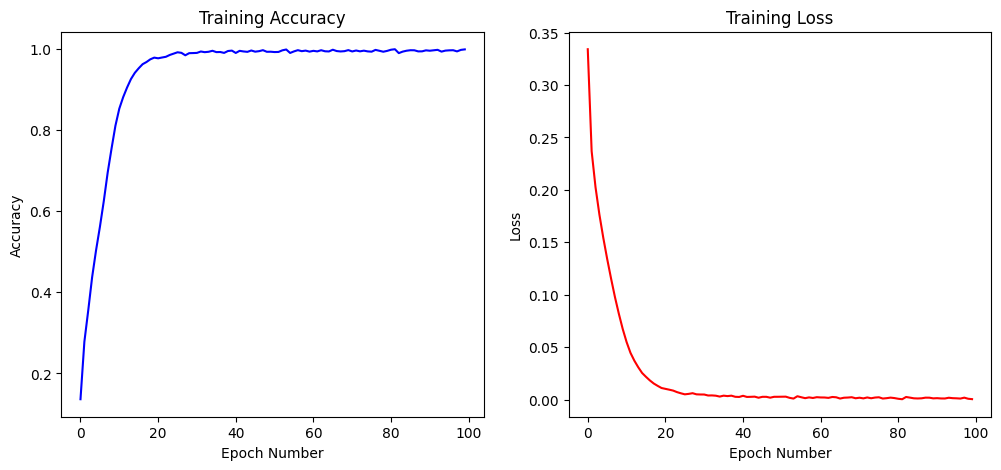

In [14]:
# Plotting accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epoch_accuracies, label='Accuracy', color='blue')
plt.title("Training Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epoch_losses, label='Loss', color='red')
plt.title("Training Loss")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")

plt.savefig(model_name_to_save.replace('.pth', '') + '-training_plot.png')

plt.show()

In [32]:
# Save all the cell outputs to a file
model_name_to_save

'vitclip-models/clip-cls-b-obstacle-tags-best.pth'